# Building an Intelligent Query Agent for Product and Service Reviews

## Overview

This tutorial demonstrates how to build an intelligent query agent using **LangGraph** that answers user queries about products and services by categorizing questions, selecting the appropriate database, and generating precise responses using structured data.

## Motivation

In a world inundated with reviews, finding relevant information can be overwhelming. Before making decisions, users often spend significant time parsing through reviews for insights. This agent addresses this challenge by:

- **Comparing Reviews:** Assisting users in evaluating two products, books, or services.
- **Recommending Items:** Offering suggestions tailored to user preferences.
- **Providing Summaries:** Delivering clear, concise descriptions of items or services.

By integrating user reviews from various sources into an intelligent system, this project demonstrates the value of combining structured data with advanced query workflows.


## Key Features

#### 1. State Management
   - Define and manage the state of each user interaction using `TypedDict`. 
   - Ensure smooth data flow across query handling steps, such as query type, database selection, and response generation.

#### 2. Query Categorization
   - Classify user queries into distinct categories:
     - **Comparison:** Evaluate differences or similarities between two entities.
     - **Recommendation:** Suggest items based on preferences.
     - **Descriptive:** Summarize or explain details about a single item.

#### 3. Database Selection
   - Route queries to the most relevant database:
     - **Amazon Books:** Reviews of books and literature.
     - **Yelp Businesses:** Reviews of restaurants, services, and businesses.
     - **IMDB Movies:** Reviews and ratings for films and series.

#### 4. Response Generation
   - Employ **Retrieval-Augmented Generation (RAG)** to craft answers by integrating structured data and language model capabilities.

#### 5. Evaluation
   - Measure response relevance and quality by assigning scores, ensuring high utility for users.

#### 6. Workflow Graph
   - Design a **LangGraph**-powered workflow that represents the entire query handling process using nodes and edges for modular, extensible implementation.

#### 7. Tracing
   - Use **LangSmith** for detailed tracing and debugging of workflows, enabling prompt optimization and better system insights.


![Review Radar](../images/review_radar.png)

## Libraries used 

- **LangChain**: Used for building a conversational pipeline.  
- **LangGraph**: Helps visualize interaction flows in the agent.  
- **LangSmith**: Tracks API calls, node outputs with the decorator.  
- **Groq**: Access LLM model execution for faster responses.  
- **FAISS**: Enables fast vector-based search for relevant documents.

### Imports and Secret Keys

Configure libraries, dependencies, and APIs.

Keys used in this tutorial are stored in .env file.
```
GROQ_API_KEY=''
LANGCHAIN_TRACING_V2=true
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_API_KEY=""
LANGCHAIN_PROJECT="review_radar"
```


In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai langchain-groq python-dotenv langchain scikit-learn faiss-cpu torch sentence-transformers

In [2]:
import getpass
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv()) # read local .env file
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

In [3]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage 
from langgraph.graph.message import add_messages 
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage
import json
from langchain_groq import ChatGroq
from langsmith import traceable
from typing import Dict, Any
from pydantic import BaseModel, Field
from pprint import pprint
import numpy as np
from groq import Groq
from typing import List, Dict
import pandas as pd
import faiss
import torch
from random import sample
from sentence_transformers import SentenceTransformer

/usr/local/anaconda3/envs/review/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare Dataset

#### Key Databases:
We took the subset of data for a set of movies, books, businesses for the purpose of hackathon. Take the data for any of the datasets available.

- **Amazon Books**: Reviews of books available on Amazon.
- **Yelp Businesse**: Reviews of businesses like restaurants and services.
- **IMDB Movies**: Reviews and ratings of movies.



In [4]:
yelp_df = pd.read_csv('../data/yelp.csv')
amazon_df = pd.read_csv('../data/amazon_books.csv')
imdb_df = pd.read_csv('../data/imdb.csv')
imdb_df = imdb_df[imdb_df['rating'].notna()]

In [5]:
yelp_df = yelp_df[['name', 'stars_x', 'text']].rename(
    columns={
        'name': 'item',
        'stars_x': 'rating',
        'text': 'review'
    }
)

imdb_df = imdb_df[['movie', 'rating', 'review_detail']].rename(
    columns={
        'movie': 'item',
        'rating': 'rating',
        'review_detail': 'review'
    }
)

amazon_df = amazon_df[['Title', 'review/score', 'review/text']].rename(
    columns={
        'Title': 'item',
        'review/score': 'rating',
        'review/text': 'review'
    }
)

## Initialise LLM

We use the Groq API to access the `llama-3.1-8b-instant` LLM.

In [6]:
from langchain_groq import ChatGroq

model = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
    max_retries=2,
)

## State Definition
Create structured data representations for managing query context, categories, and database selections.

In [7]:
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    category: str = Field(description="to store the selected category from (Comparison, Descriptive, Recommendation)")
    db_type: str = Field(description="to store the selected database from (IMDB, Amazon, Yelp)")

## Classification Node

Classify the query into one of the categories (Comparison, Descriptive, Recommendation) using a custom prompt.

In [8]:
class ClassificationNodeOutput(BaseModel):
    query: str = Field(description="The query from the user")
    category: str = Field(description="The type of the category: descriptive, comparison, or recommendation")
    db: str = Field(description="The type of the database to search from: amazon, imdb, or yelp")


@traceable
class ClassificationNode():
    @staticmethod
    @traceable
    def classify_query(state: AgentState):
        parser = PydanticOutputParser(pydantic_object=ClassificationNodeOutput)

        classification_prompt_template = (
            """
            Classify the user query into one of the following categories:  
            - Descriptive: if the user is asking for general information or details about a particular subject.  
            - Comparison: if the user is comparing two or more items to understand which one is better or to see differences.  
            - Recommendation: if the user is seeking suggestions or advice for a particular choice.  

            Based on the query, also choose the most appropriate database from the following options:  
            - Amazon: for product-related queries or recommendations.  
            - IMDb: for movie or TV show-related queries, comparisons, or recommendations.  
            - Yelp: for queries related to restaurants, businesses, or local services.  

            Examples:  
            - Descriptive: "What is the best movie of all time?" -> Database: IMDb  
            - Comparison: "Which movie is better, Inception or Interstellar?" -> Database: IMDb  
            - Recommendation: "Suggest some good restaurants nearby." -> Database: Yelp  

            Your task:  
            Given the user query below, classify it into one of the categories (descriptive, comparison, recommendation) and choose the appropriate database (amazon, imdb, yelp).  

            {format_instructions}  

            Query: {query}

            """
        )

        classification_prompt = PromptTemplate(
                        template=classification_prompt_template, 
                        input_variables=["query"],
                        partial_variables={"format_instructions": parser.get_format_instructions()},
                    )
        classification_model = classification_prompt | model
        query = state["messages"][0].content
        output = classification_model.invoke({"query": query})
        response: ClassificationNodeOutput = parser.invoke(output)
        AIMessageresponse = AIMessage(content=json.dumps(response.model_dump()), name="classification_node" ,additional_kwargs = {"query": query, "json_output": response.model_dump()})
        return {"messages": [AIMessageresponse], "category": response.category, "db_type": response.db,}


## Category Nodes
Each category node (Recommendation, Comparison, Descriptive) generates the structured output with the fields mentioned below. 

In [9]:
from abc import ABC, abstractmethod

class Category(ABC):
    @abstractmethod
    def process_query(state: AgentState):
        """Process the query based on the category type."""
        pass


In [27]:
class DescriptivePromptOutput(BaseModel):
    query: str = Field(description="The query from the user.")
    primary_focus: str = Field(description="The primary category or topic type of the query (e.g., 'movies', 'technology', 'books').")
    keywords: Sequence[str] = Field(description="A list of keywords and phrases extracted from the query that will assist in semantic search.")


@traceable
class DescriptiveCategory(Category):
    @staticmethod
    @traceable
    def process_query(state: AgentState):
        parser = PydanticOutputParser(pydantic_object=DescriptivePromptOutput)

        descriptive_prompt_template = (
            """
            You are an expert in descriptive analysis, specializing in creating comprehensive lists of key elements, Themes, or characteristics that are central to answering detailed query.
            Your goal is to produce a detailed list of concepts, keywords, and specific features related to the main topic of the query:

            {query}

            To structure your response:
            1. **Analyze the query**: Identify the main topic and any specific subcategories or descriptors implied in the query.
            2. **Generate a List of Keywords**: Think about genres, notable characteristics, influential figures, popular examples, and historical context relevant to the query. Include broad themes and specific details.
            3. **Support Semantic Search**: Ensure that each keyword or phrase will enhance the relevance of results in a vector database search.

            the output should be structured as follows:
                    "query": 'What is the best science fiction movie of all time?',
                    "primary_focus": 'movies',
                    "keywords": ['science fiction genre', 'top-rated movies', 'popular sci-fi themes',]
            
            REMEMBER: Your analysis should be structured, detailed, and relevant to the query. 
            DONT ADD ANYTHING ELSE TO THE OUTPUT.
            DONT FORGET to add the query, primary focus, and keywords to the JSON response.
            You must always return valid JSON fenced by a markdown code block. Do not return any additional text.
            """
        )

        prompt = PromptTemplate(
                    template=descriptive_prompt_template,
                    input_variables=["query"],
                    partial_variables={"format_instructions": parser.get_format_instructions()},
                )

        descriptive_model = prompt | model
        query = state["messages"][0].content
        output = descriptive_model.invoke({"query": query})
        response: DescriptivePromptOutput = parser.invoke(output)
        AIMessageresponse = AIMessage(content=json.dumps(response.model_dump()), name="descriptive_node" ,additional_kwargs = {"query": query, "json_output": response.model_dump()})
        return {"messages": [AIMessageresponse],}


In [11]:
class RecommendationPromptOutput(BaseModel):
    query: str = Field(description="the query from the user")
    category: str = Field(description="the category/field of the items being recommendation")
    criteria: Sequence[str] = Field(description="the criteria for recommendation, optimized for semantic search relevance")

@traceable
class RecommendationCategory(Category):
    @staticmethod
    @traceable
    def process_query(state: AgentState):
        parser = PydanticOutputParser(pydantic_object=RecommendationPromptOutput)

        recommendation_prompt_template = (
            """You are an expert recommendation analyst. Your task is to analyze this query: {query}

                Your role is to:
                1. Determine the category/field for the query
                2. Generate relevant criteria to make top recommendations
                3. Structure the output as JSON

                **Example criteria by category:**

                MOVIES:
                - Genre alignment with viewer interests
                - Audience ratings and review sentiment
                - Plot originality and complexity
                - Character and actor performance
                - Publicity events for movie promotions
                - Actors familiarity and fan following
                - Technical quality (cinematography, effects, vfx, screenplay)
                - Legacy and cultural relevance
                - Relatability to the viewer
                - Unique factor to attract the audience

                RESTAURANTS:
                - Food quality (ingredients, freshness)
                - Price range and value for money
                - Ambiance (interior design, atmosphere)
                - Chef expertise and background
                - Preparation techniques (traditional, fusion)
                - Menu authenticity
                - Accessibility (location, parking)
                - Customer feedback and service
                - Specialty offerings (unique dishes, chef’s expertise)
                - Cultural dining practices
                - Take out options
                - Dietary accomodations (Vegetarian, vegan)

                BOOKS:
                - Genre suitability
                - Reader engagement (plot, character depth)
                - Book popularity 
                - Awards and features for the author and book
                - Writing style and originality
                - Critical reviews and ratings
                - Influence and cultural impact
                - Author reputation
                - Level of reader
                - Language of the book written in 
                - References and sources


                the output should be structured as follows:
                    "query": "query",
                    "category": "category",
                    "criteria": ["criterion1", "criterion2"]


                REMEMBER: Your analysis should be structured, detailed, and relevant to the query. 
                DONT ADD ANYTHING ELSE TO THE OUTPUT.
                You must always return valid JSON fenced by a markdown code block. Do not return any additional text.
                """
            )

        prompt = PromptTemplate(
                    template=recommendation_prompt_template,
                    input_variables=["query"],
                    partial_variables={"format_instructions": parser.get_format_instructions()},
                )

        recommendation_model = prompt | model
        query = state["messages"][0].content
        output = recommendation_model.invoke({"query": query})
        response: RecommendationPromptOutput = parser.invoke(output)
        AIMessageresponse = AIMessage(content=json.dumps(response.model_dump()), name="recommendation_node" ,additional_kwargs = {"query": query, "json_output": response.model_dump()})
        return {"messages": [AIMessageresponse],}

In [12]:
class ComparisonPromptOutput(BaseModel):
    query: str = Field(description="the query from the user")
    items: Sequence[str] = Field(description="the items being compared")
    category: str = Field(description="the category/field of the items being compared")
    criteria: Sequence[str] = Field(description="the criteria for comparison, optimized for semantic search relevance")

@traceable
class ComparisonCategory(Category):
    @staticmethod
    @traceable
    def process_query(state: AgentState):
        parser = PydanticOutputParser(pydantic_object=ComparisonPromptOutput)

        comparison_prompt_template = (
           """You are an expert comparison analyst specialized in structured analysis. Your task is to analyze this query: {query}

            Your role is to:
            1. Identify the items being compared
            2. Determine their category/field
            3. Create relevant comparison criteria
            4. Ensure the criteria list contains keywords and phrases that will optimize relevance in a semantic search, particularly for use in a vector database.
            5. Structure the output as JSON

            Example criteria by category:

            MOVIES:
            - Genre alignment
            - Audience ratings and review sentiment
            - Plot complexity and originality
            - Character development
            - Technical aspects (effects, cinematography)
            - Cultural impact and legacy

            BOOKS:
            - Genre and thematic alignment
            - Writing style and readability
            - Character development and depth
            - Plot complexity and originality
            - Critical reviews and reader sentiment
            - Author reputation and influence
            - Cultural impact and legacy

            RESTAURANTS/SERVICES:
            - Quality of service/food
            - Price range comparison
            - Atmosphere and ambiance
            - Location and accessibility
            - Customer satisfaction metrics
            - Unique selling points

            the output should be structured as follows:
                "query": "query",
                "items": ["item1", "item2"],
                "category": "category",
                "criteria": ["criterion1", "criterion2"]


            REMEMBER: Your analysis should be structured, detailed, and relevant to the query. 
            DONT ADD ANYTHING ELSE TO THE OUTPUT.
            You must always return valid JSON fenced by a markdown code block. Do not return any additional text.
            """
        )

        prompt = PromptTemplate(
                    template=comparison_prompt_template,
                    input_variables=["query"],
                    partial_variables={"format_instructions": parser.get_format_instructions()},
                )

        comparison_model = prompt | model
        query = state["messages"][0].content
        output = comparison_model.invoke({"query": query})
        response: ComparisonPromptOutput = parser.invoke(output)
        AIMessageresponse = AIMessage(content=json.dumps(response.model_dump()), name="comparison_node" ,additional_kwargs = {"query": query, "json_output": response.model_dump()})
        return {"messages": [AIMessageresponse],}


## Conditional edge
Choose a category node using this conditional edge.

In [13]:
def identify_category(state: AgentState):
    return state["category"].lower()

## RAG Pipeline

Retrieval-Augmented Generation (RAG) pipeline using FAISS for efficient similarity search, enabling the retrieval of relevant documents from a dataset. The pipeline processes different types of queries—comparison, descriptive, and recommendation—by extracting context and generating responses using a language model (Groq) and a reviews dataset.

In [14]:
class RAGPipeline:
    """
    RAG implementation using FAISS vector database for efficient similarity search
    """
    def __init__(self,
                 df,
                 embedding_model: str = 'all-MiniLM-L6-v2',
                 llm_model: str = "llama-3.1-8b-instant"):
        """
        Initialize the RAG system with FAISS vector store
        
        Args:
            embedding_model (str): Name of the sentence-transformers model
            groq_api_key (str): API key for Groq
            llm_model (str): Name of the Groq model to use
        """
        self.encoder = SentenceTransformer(embedding_model)
        self.groq_client = Groq()
        self.llm_model = llm_model
        self.index = None
        self.df = df
        self.dimension = None
        
    def create_index(self, batch_size: int = 32):
        """
        Create FAISS index from dataframe texts
        
        Args:
            batch_size (int): Batch size for processing embeddings
        """
        self.df = self.df.copy()
        texts = self.df["review"].fillna('').tolist()
        
        # Generate embeddings in batches
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            with torch.no_grad():
                batch_embeddings = self.encoder.encode(batch, convert_to_numpy=True)
            embeddings.append(batch_embeddings)
        
        embeddings = np.vstack(embeddings)
        self.dimension = embeddings.shape[1]
        
        # Initialize FAISS index
        self.index = faiss.IndexFlatL2(self.dimension)
        # Add vectors to the index
        self.index.add(embeddings.astype('float32'))
        
        print(f"Created FAISS index with {len(texts)} vectors of dimension {self.dimension}")

        
    def save_index(self, index_path: str):
        """
        Save the FAISS index and DataFrame to disk
        
        Args:
            index_path (str): Path to save the FAISS index
            df_path (str): Path to save the DataFrame
        """
        faiss.write_index(self.index, index_path)
        print(f"Saved index to {index_path}")

        
    def load_index(self, index_path: str):
        """
        Load the FAISS index from disk
        
        Args:
            index_path (str): Path to load the FAISS index from
        """
        self.index = faiss.read_index(index_path)
        self.dimension = self.index.d
        print(f"Loaded index with {self.index.ntotal} vectors of dimension {self.dimension}")


    def retrieve_relevant_documents(self, query: str, top_k: int=10) -> Dict:
        """
        Retrieve the most relevant documents given the query

        Args: query (str): Query text
            top_k (int): Number of most relevant documents to retrieve
            
        Returns:
            str: Retrieved Context
        """
        if self.index is None:
            raise ValueError("Index not created. Please create or load an index first.")
            
        # Generate query embedding
        with torch.no_grad():
            query_embedding = self.encoder.encode([query], convert_to_numpy=True)
        
        # Search in FAISS index
        distances, indices = self.index.search(query_embedding.astype('float32'), top_k)
        
        # Get relevant documents
        relevant_docs = self.df.iloc[indices[0]]["review"].tolist()
        
        # Convert L2 distances to similarity scores (smaller distance = higher similarity)
        max_distance = np.max(distances) + 1e-6  # Avoid division by zero
        similarity_scores = 1 - (distances[0] / max_distance)  # Normalize to [0,1]
        
        # Prepare context
        context = "\n\n".join([f"Document (relevance: {score:.2f}): {doc}" 
                              for doc, score in zip(relevant_docs, similarity_scores)])
        
        return context

    
    def comparison_query(self, query: str, context: Dict) -> Dict:
        """
        Answer the Comparison type query using RAG
        Args:
            query (str): Query text
            
        Returns:
            Dict: Contains retrieved context and generated response
        """

        retrieved_context = self.retrieve_relevant_documents(query, 30)
        criteria = context["messages"][-1].additional_kwargs["json_output"]["criteria"]
        items = context["messages"][-1].additional_kwargs["json_output"]["items"]

        prompt_template = """You will be given a query which asks you to compare two items, criteria on which you need to compare those items, and some audience/user reviews related to the query obtained from a reviews dataset. 
        This query requires you to compare the two items, {items}. You will be given the metrics on the basis of which you should compare the two items. 
        Using the given information, give a detailed comparison of the two items. 
        If the answer cannot be derived from the context, say so.

        Question: {query}

        Items: {items}

        Criteria: {criteria}

        Reviews: {retrieved_context}

        Answer:"""

        prompt = PromptTemplate(template=prompt_template, 
                                input_variables=["items", "query", "criteria", "retrieved_context"])
        
        model = ChatGroq(model="llama-3.1-8b-instant", 
                         temperature=0.1, 
                         timeout=None, 
                         max_retries=2)
        
        comparison_model = prompt | model
        
        output = comparison_model.invoke({"items": items, "query": query, "criteria": criteria, "retrieved_context": retrieved_context})
        response = output.content
        
        return {
            'query': query,
            'retrieved_context': context,
            'response': response
        }
    
    
    def descriptive_query(self, query: str, context: Dict) -> Dict:
        """
        Answer the Descriptive query using RAG
        
        Args:
            query (str): Query text
            
        Returns:
            Dict: Contains retrieved context and generated response
        """
        keywords = context["messages"][-1].additional_kwargs["json_output"]["keywords"]
        keywords_sample = sample(keywords, 5)
        keywords_str = " ".join(keywords_sample)

        retrieved_context = self.retrieve_relevant_documents(query + " Keywords: " + keywords_str, 20)

        prompt_template = """You will be given a query, some keywords related to the query, and some audience/user reviews related to the query obtained from a reviews dataset. 
        This query will ask you to describe something related to an item such as a movie, book or restaurant. Use the details mentioned in the reviews to answer the 
        query. Give a detailed answer to the query. 
        Using this information, provide a comprehensive answer. If the answer cannot be derived from the context, say so.

        Question: {query}

        Keywords: {keywords}

        Reviews: {retrieved_context}

        Answer:"""

        prompt = PromptTemplate(template=prompt_template, 
                                input_variables=["query", "keywords", "retrieved_context"])
        
        model = ChatGroq(model="llama-3.1-8b-instant", 
                         temperature=0.1,
                         timeout=None, 
                         max_retries=2)
        
        descriptive_model = prompt | model
        
        output = descriptive_model.invoke({"query": query, "keywords": keywords, "retrieved_context": retrieved_context})
        response = output.content
        
        return {
            'query': query,
            'retrieved_context': context,
            'response': response
        }
    

    def recommendation_query(self, query: str, context: Dict) -> Dict:
        """
        Answer the Recommendation type query using RAG
        
        Args:
            query (str): Query text
            
        Returns:
            Dict: Contains retrieved context and generated response
        """

        retrieved_context = self.retrieve_relevant_documents(query, 30)
        criteria = context["messages"][-1].additional_kwargs["json_output"]["criteria"]

        prompt_template = """You will be given a query which would ask you for recommendations, some criteria on the basis of which you can provide recommendations
        and some audience/user reviews related to the query obtained from a reviews dataset. 
        Use the query and the criteria given along with the reviews to recommend items to the user.
        If the answer cannot be derived from the context, say so.

        Question: {query}

        Criteria:
        {criteria}

        Reviews: {retrieved_context}

        Answer:"""

        prompt = PromptTemplate(template=prompt_template, 
                                input_variables=["query", "criteria", "retrieved_context"])
        
        model = ChatGroq(model="llama-3.1-8b-instant", 
                         temperature=0.1,
                         timeout=None, 
                         max_retries=2)
        
        recommendation_model = prompt | model
        
        output = recommendation_model.invoke({"query": query, "criteria": criteria, "retrieved_context": retrieved_context})
        response = output.content
        
        return {
            'query': query,
            'retrieved_context': context,
            'response': response
        }

### Vector DataStore
Create index on FAISS embeddings for each database and create a vector store. 

In [15]:
imdb_rag_system = RAGPipeline(imdb_df)
if not os.path.exists("imdb_faiss_index.idx"):
    imdb_rag_system.create_index()
    imdb_rag_system.save_index("imdb_faiss_index.idx")
else:
    imdb_rag_system.load_index("imdb_faiss_index.idx")

yelp_rag_system = RAGPipeline(yelp_df)
if not os.path.exists("yelp_faiss_index.idx"):
    yelp_rag_system.create_index()
    yelp_rag_system.save_index("yelp_faiss_index.idx")
else:
    yelp_rag_system.load_index("yelp_faiss_index.idx")

amazon_rag_system = RAGPipeline(amazon_df)
if not os.path.exists("amazon_faiss_index.idx"):
    amazon_rag_system.create_index()
    amazon_rag_system.save_index("amazon_faiss_index.idx")
else:
    amazon_rag_system.load_index("amazon_faiss_index.idx")

Loaded index with 2872 vectors of dimension 384
Loaded index with 1600 vectors of dimension 384
Loaded index with 3000 vectors of dimension 384


### Hash Map to store RAG for each database 

In [16]:
db_to_rag_pipeline = {"imdb": imdb_rag_system, 
                      "yelp": yelp_rag_system, 
                      "amazon": amazon_rag_system}

## Run RAG Pipeline

In [17]:
@traceable
def generate_rag_response(state: AgentState):
    query = state["messages"][0].content
    db_type = state["db_type"].lower()
    category = state["category"].lower()
    
    rag_pipeline = db_to_rag_pipeline[db_type]
    
    response = {}
    if category == "descriptive":
        response = rag_pipeline.descriptive_query(query, state)
    elif category == "comparison":
        response = rag_pipeline.comparison_query(query, state)
    elif category == "recommendation":
        response = rag_pipeline.recommendation_query(query, state)
    
    AIMessageresponse = AIMessage(content=response["response"], name="RAG_node", additional_kwargs={"query" : query ,"json_output": response})
    return {"messages" : [AIMessageresponse]}
    

## Evaluator Node
Assess the generated responses, scoring their relevance and clarity.

In [ ]:
class EvalType(BaseModel):
    score: str = Field(description="Score from 0-100 according to match")
    summary: str = Field(description="Summary of the evaluation")

@traceable
def evaluate_output(state: AgentState):
    last_massage = state["messages"][-1]
    original_query = state["messages"][0].content
    response = last_massage.content
    parser = PydanticOutputParser(pydantic_object=EvalType)

    eval_prompt_template = (
            """
            You are an expert evaluator. Your task is to grade the following output on a scale of 0-100%, where 0 is poor match and 100 is excellent match with exact keywords. 
            Consider the following criteria:
            - Relevance to the original query
            - Accuracy of information
            - Clarity and coherence
            - Completeness of the answer
            - Semantic similarity

            Original query: {original_query}
            Output to evaluate: {response}

            Provide your score in JSON format:

            {{
                "score": "76",  # Example score as a string
                "summary": "evaluation summary"  # Example summary
            }}
            
            YOU MUST ALWYAS return valid JSON fenced by a markdown code block. Do not return any additional text.
    """
    )

    prompt = PromptTemplate(
                template=eval_prompt_template,
                input_variables=["original_query", "response"],
                partial_variables={"format_instructions": parser.get_format_instructions()},
            )

    eval_model = prompt | model

    evaluation = eval_model.invoke({"original_query": original_query, "response": response})

    response : EvalType = parser.invoke(evaluation)
    AIMessageresponse = AIMessage(content=json.dumps(response.model_dump()), name="evaluation_node", additional_kwargs={"query": original_query, "json_output": response.model_dump()})
    return {"messages": [AIMessageresponse]}

### LangSmith Dashboard

To monitor and analyze API interactions with the LLM, we used the `@traceable` decorator from LangSmith. This allowed us to trace every step of the pipeline, capturing inputs, outputs, and performance metrics in real-time. By visualizing this data in the LangSmith dashboard, we could optimize model selection and refine our workflow.

**Tutorial Steps:**
1. **Enable Tracking:** Decorate each function or node in your pipeline with `@traceable`.
2. **Visualize Insights:** Access the LangSmith dashboard to review tracked API calls, latency, and responses.
3. **Iterate and Improve:** Use the insights to select the most suitable model and refine queries for better results.

Below is a snapshot from the LangSmith dashboard illustrating how we tracked and analyzed requests:

![Review Radar-LangSmith Dashboard](../images/review_radar_lang_smith.png)

## Workflow and examples

In [29]:
from langgraph.graph import StateGraph, END

@traceable
def run_workflow():
    workflow = StateGraph(AgentState)

    workflow.add_node("classification_node", ClassificationNode.classify_query)

    workflow.add_node("comparison_node", ComparisonCategory.process_query)
    workflow.add_node("recommendation_node", RecommendationCategory.process_query)
    workflow.add_node("descriptive_node", DescriptiveCategory.process_query)

    workflow.add_node("RAG", generate_rag_response)
    workflow.add_node("evaluation_node", evaluate_output)


    workflow.set_entry_point("classification_node")

    workflow.add_conditional_edges("classification_node", identify_category,
        {
            "comparison": "comparison_node",
            "recommendation": "recommendation_node",
            "descriptive": "descriptive_node",                                           
        })

    workflow.add_edge("comparison_node", "RAG")
    workflow.add_edge("recommendation_node", "RAG")
    workflow.add_edge("descriptive_node", "RAG")

    workflow.add_edge("RAG", "evaluation_node")
    workflow.add_edge("evaluation_node", END)

    return workflow


agent_graph = run_workflow().compile()

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [30]:
@traceable
def stream_graph(stream):
    for s in stream:
        
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            if message.name:
                if message.type == "ai":
                    print(f'\n\n================================== \033[1m{message.name.upper()} AI Message\033[0m ==================================\n\n')
                pprint(message.additional_kwargs["json_output"])
            else:
                message.pretty_print()

In [32]:
descriptive_inputs = {"messages": [("user", "Mention amazing points in the plot of the book Harry Potter, Goblet of Fire according to the reviewers?")]}
stream_graph(agent_graph.stream(descriptive_inputs, stream_mode="values"))

================================ Human Message =================================

Mention amazing points in the plot of the book Harry Potter, Goblet of Fire according to the reviewers?


================================== CLASSIFICATION_NODE AI Message ==================================


{'category': 'descriptive',
 'db': 'imdb',
 'query': 'Mention amazing points in the plot of the book Harry Potter, Goblet '
          'of Fire according to the reviewers?'}


================================== DESCRIPTIVE_NODE AI Message ==================================


{'keywords': ['Harry Potter and the Goblet of Fire',
              'J.K. Rowling',
              'plot twists',
              'Triwizard Tournament',
              'Cedric Diggory',
              "Lord Voldemort's return",
              'Barty Crouch Jr.',
              "Moody's true identity",
              "Hagrid's role",
              'Quidditch World Cup',
              "Weasley's Wildfire Whiz-bangs",
              "Goblet o

In [ ]:
comparison_input = {"messages": [("user", "What should I watch Doom or Rent movie next, which is the reviewers choice?")]}
stream_graph(agent_graph.stream(comparison_input, stream_mode="values"))

================================ Human Message =================================

What should I watch Doom or Rent movie next, which is the reviewers choice?


================================== CLASSIFICATION_NODE AI Message ==================================


{'category': 'comparison',
 'db': 'imdb',
 'query': 'What should I watch Doom or Rent movie next, which is the reviewers '
          'choice?'}


================================== COMPARISON_NODE AI Message ==================================


{'category': 'MOVIES',
 'criteria': ['Genre alignment',
              'Audience ratings and review sentiment',
              'Plot complexity and originality',
              'Character development',
              'Technical aspects (effects, cinematography)',
              'Cultural impact and legacy'],
 'items': ['Doom', 'Rent'],
 'query': 'Doom vs Rent movie'}


================================== RAG_NODE AI Message ==================================


{'query': 'What should I watch Do

In [ ]:
recommendation_input = {"messages": [("user", "Recommend the best restaurant in Las Vegas according to the reviews")]}
stream_graph(agent_graph.stream(recommendation_input, stream_mode="values"))

================================ Human Message =================================

Recommend the best restaurant in Las Vegas according to the reviews


================================== CLASSIFICATION_NODE AI Message ==================================


{'category': 'recommendation',
 'db': 'yelp',
 'query': 'Recommend the best restaurant in Las Vegas according to the reviews'}


================================== RECOMMENDATION_NODE AI Message ==================================


{'category': 'RESTAURANTS',
 'criteria': ['Food quality (ingredients, freshness)',
              'Price range and value for money',
              'Ambiance (interior design, atmosphere)',
              'Chef expertise and background',
              'Preparation techniques (traditional, fusion)',
              'Menu authenticity',
              'Accessibility (location, parking)',
              'Customer feedback and service',
              'Specialty offerings (unique dishes, chef’s expertise)',
            

## Workflow Graph

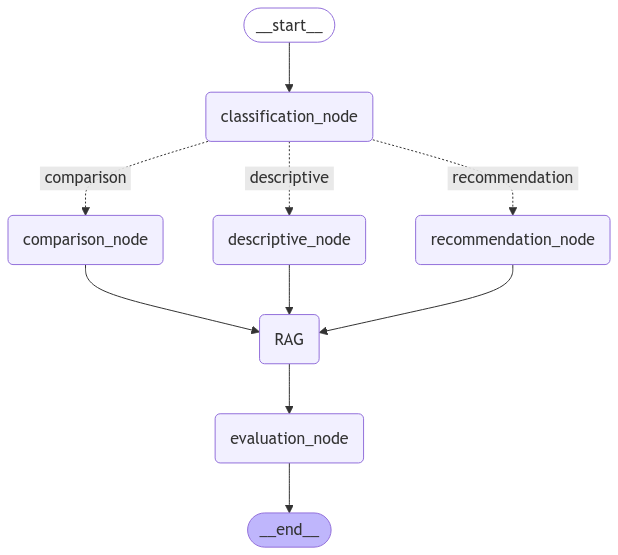

In [ ]:
from IPython.display import Image, display

try:
    display(Image(agent_graph.get_graph().draw_mermaid_png()))
except Exception:
    pass